# Paso 1: Importar librerías y cargar datos

In [ ]:
## Paso 1: Importar librerías necesarias
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Cargar dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('/data/training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1', names=columns)

In [ ]:
# Mostrar las primeras filas del dataset
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 6)

In [ ]:
# Verificar información general del dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


In [ ]:
df['target'].value_counts()

,count
target,
0,800000
4,800000


#  Paso 2: Preprocesamiento de Datos

In [ ]:
## Paso 2: Preprocesamiento de Datos

# Eliminar columnas innecesarias
df = df[['target', 'text']]

# Reasignar valores de la variable target (0 = Negativo, 4 = Positivo → 0 y 1)
df['target'] = df['target'].map({0: 0, 4: 1})

# Definir stopwords en español e inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar texto
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'http\S+', '', texto)  # Eliminar URLs
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar signos de puntuación
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stop_words]  # Eliminar stopwords
    return ' '.join(palabras)




In [ ]:
# Aplicar limpieza a la columna 'text'
df['text_clean'] = df['text'].apply(limpiar_texto)

# Verificar cambios
df.head()

,target,text,text_clean
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats bummer shoulda got david...
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save re...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see


# Paso 3: Análisis Exploratorio (Gráficos y Nube de Palabras)

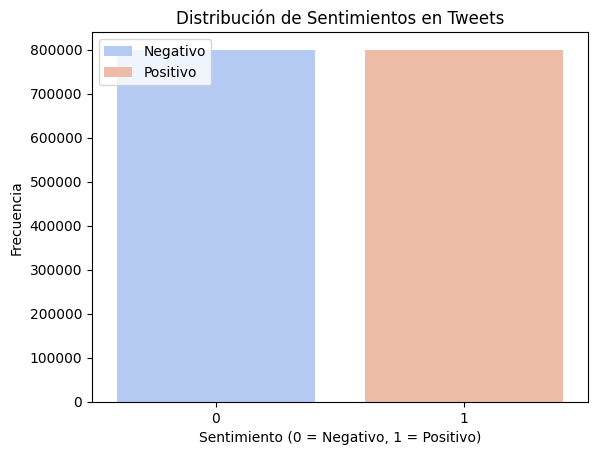

In [ ]:
## Paso 3: Análisis Exploratorio

# Distribución de tweets positivos y negativos
sns.countplot(x=df['target'], hue=df['target'], palette='coolwarm')
plt.title("Distribución de Sentimientos en Tweets")
plt.xlabel("Sentimiento (0 = Negativo, 1 = Positivo)")
plt.ylabel("Frecuencia")
plt.legend(['Negativo', 'Positivo'], loc='upper left')
plt.show()

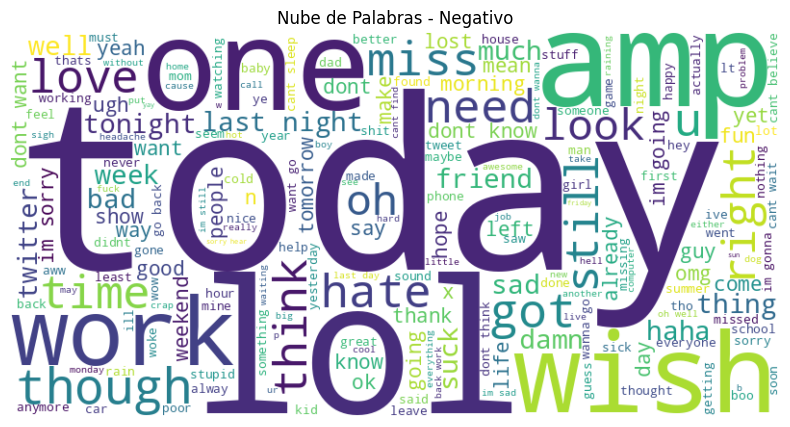

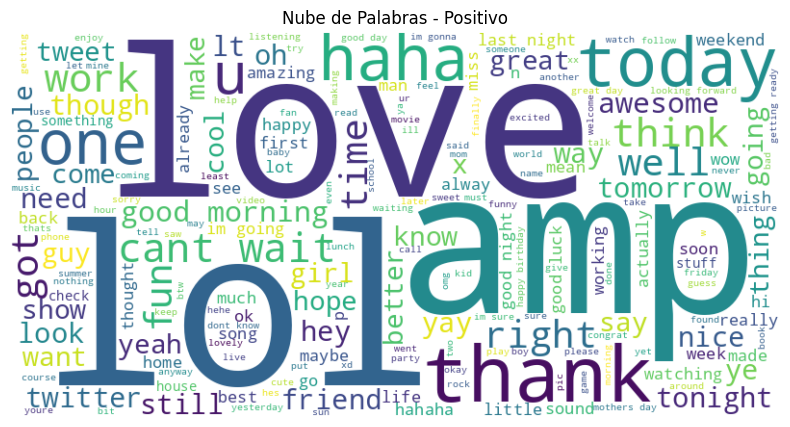

In [ ]:
# Generar nube de palabras para cada sentimiento
for sentimiento in [0, 1]:
    texto = " ".join(df[df['target'] == sentimiento]['text_clean'])
    nube_palabras = WordCloud(width=800, height=400, background_color="white").generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(nube_palabras, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de Palabras - {'Negativo' if sentimiento == 0 else 'Positivo'}")
    plt.show()

# Paso 4: Vectorización de Texto

Justificación: Usamos ``TF-IDF`` porque:
- Da más peso a palabras relevantes en comparación con CountVectorizer.
- Reduce el impacto de palabras comunes en el corpus.

In [ ]:
## Paso 4: Vectorización de Texto

# Definir vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # Limitar a las 10,000 palabras más frecuentes

# Aplicar vectorización
X = vectorizer.fit_transform(df['text_clean'])

# Definir variable objetivo
y = df['target'].values

# Dividir datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar dimensiones de los conjuntos
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (1280000, 10000), X_test: (320000, 10000)


# Paso 5: Entrenamiento con Regresión Logística

In [ ]:
## Paso 5: Entrenamiento con Regresión Logística

# Definir el modelo
logistic_model = LogisticRegression()

# Entrenar el modelo
logistic_model.fit(X_train, y_train)

# Predicciones en test
y_pred = logistic_model.predict(X_test)

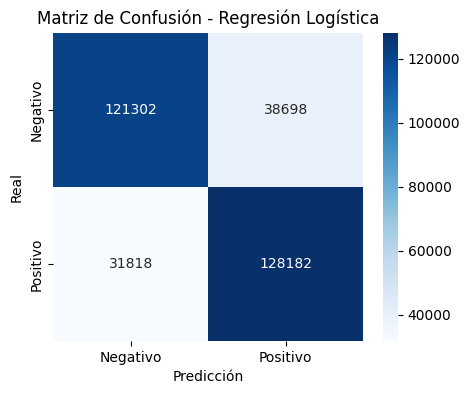

In [ ]:
# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


In [ ]:
# Evaluar el modelo
print("\nMétricas - Regresión Logística")
print(classification_report(y_test, y_pred))



Métricas - Regresión Logística
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# Paso 6: Entrenamiento con Random Forest

In [ ]:
## Paso 6: Entrenamiento con Random Forest

# Definir modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1234, n_jobs=-1)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predicciones en test
y_pred_rf = rf_model.predict(X_test)

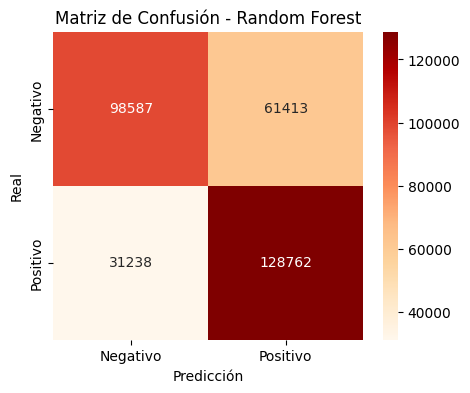

In [ ]:
# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='OrRd', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [ ]:
# Evaluar el modelo
print("\nMétricas - Random Forest")
print(classification_report(y_test, y_pred_rf))




Métricas - Random Forest
              precision    recall  f1-score   support

           0       0.76      0.62      0.68    160000
           1       0.68      0.80      0.74    160000

    accuracy                           0.71    320000
   macro avg       0.72      0.71      0.71    320000
weighted avg       0.72      0.71      0.71    320000



# Paso 7: Prueba con Tweets Nuevos

In [ ]:
## Paso 7: Prueba con nuevos tweets

# Definir nuevos tweets (uno positivo y uno negativo)
nuevo_tweet_positivo = "I love this product! It's absolutely amazing and makes my life so much easier!"
nuevo_tweet_negativo = "This is the worst experience I've ever had. Totally disappointed and frustrated."

# Función para preprocesar un tweet nuevo
def preprocesar_tweet(tweet):
    tweet = tweet.lower()  # Convertir a minúsculas
    tweet = re.sub(r'http\S+', '', tweet)  # Eliminar URLs
    tweet = re.sub(r'\d+', '', tweet)  # Eliminar números
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Eliminar signos de puntuación
    palabras = tweet.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords.words('english')]  # Eliminar stopwords
    return ' '.join(palabras)

# Preprocesar los tweets
tweet_positivo_clean = preprocesar_tweet(nuevo_tweet_positivo)
tweet_negativo_clean = preprocesar_tweet(nuevo_tweet_negativo)

# Convertir a representación numérica usando el vectorizador TF-IDF entrenado
tweet_positivo_vectorizado = vectorizer.transform([tweet_positivo_clean])
tweet_negativo_vectorizado = vectorizer.transform([tweet_negativo_clean])

# Hacer predicciones con logistic_model
prediccion_positivo = logistic_model.predict(tweet_positivo_vectorizado)[0]
prediccion_negativo = logistic_model.predict(tweet_negativo_vectorizado)[0]

# Mostrar resultados
print("\n🔍 **Resultados de predicción en tweets nuevos**")
print(f"Tweet positivo: \"{nuevo_tweet_positivo}\" → Predicción: {'Positivo 😊' if prediccion_positivo == 1 else 'Negativo 😡'}")
print(f"Tweet negativo: \"{nuevo_tweet_negativo}\" → Predicción: {'Positivo 😊' if prediccion_negativo == 1 else 'Negativo 😡'}")


🔍 **Resultados de predicción en tweets nuevos**
Tweet positivo: "I love this product! It's absolutely amazing and makes my life so much easier!" → Predicción: Positivo 😊
Tweet negativo: "This is the worst experience I've ever had. Totally disappointed and frustrated." → Predicción: Negativo 😡
